In [81]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import lasio
import matplotlib.pyplot as plt
import missingno as msno

In [71]:
# Function to calculate porosity (simple example using sonic porosity)
def calculate_porosity(DT):
    # Using a simple empirical relationship for porosity from sonic log (DT)
    # Porosity in percentage from sonic log
    phi = (DT - 45) / (200 - 45)
    return phi

# Function to calculate permeability (using empirical correlation)
def calculate_permeability(phi, DT):
    # Simple empirical correlation (example)
    K = 0.1 * phi**3 / DT
    return K

# Function to calculate resistivity (using log)
def calculate_resistivity(ILD):
    # Placeholder, since actual resistivity would require ILD values
    Rt = ILD
    return Rt


              ASN  CALI  CILD  DT  GR  ILD  NEUT  SN        SP
DEPT                                                          
68.0     0.065541   NaN   NaN NaN NaN  NaN   NaN NaN -73.43595
68.5     0.065541   NaN   NaN NaN NaN  NaN   NaN NaN -73.43595
69.0     0.065541   NaN   NaN NaN NaN  NaN   NaN NaN -74.53538
69.5     0.065576   NaN   NaN NaN NaN  NaN   NaN NaN -76.57851
70.0     0.063046   NaN   NaN NaN NaN  NaN   NaN NaN -78.16614
...           ...   ...   ...  ..  ..  ...   ...  ..       ...
22006.0       NaN   NaN   NaN NaN NaN  NaN   NaN NaN -56.13889
22006.5       NaN   NaN   NaN NaN NaN  NaN   NaN NaN -56.10113
22007.0       NaN   NaN   NaN NaN NaN  NaN   NaN NaN -56.06306
22007.5       NaN   NaN   NaN NaN NaN  NaN   NaN NaN -56.07770
22008.0       NaN   NaN   NaN NaN NaN  NaN   NaN NaN -56.13981

[43881 rows x 9 columns]


<Axes: >

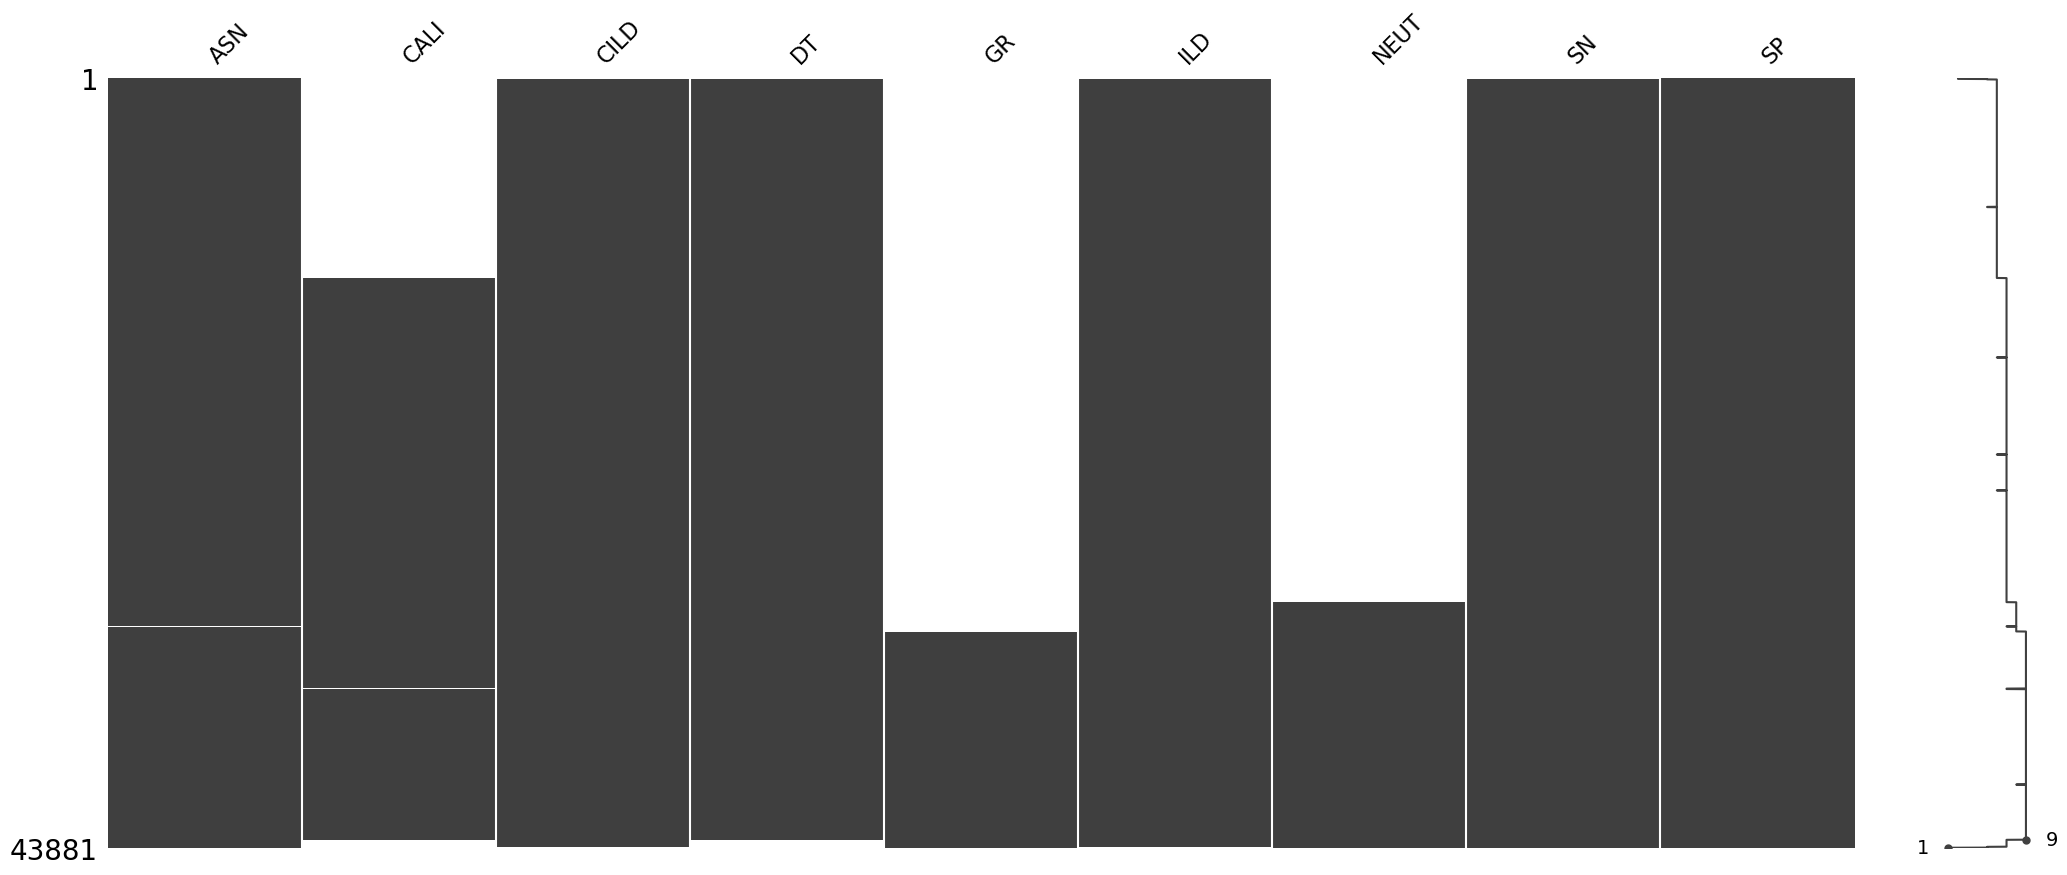

In [72]:
# Data input
las = lasio.read('C:/Users/binta/Downloads/42283002040000_A_M_FOERSTER_1.las')
data = las.df()

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the results
print(df)

# Reading Data
msno.matrix(df)

               ASN       CALI       CILD        DT          GR        ILD  \
DEPT                                                                        
15840.0  25.689130  12.615200   11.07158  49.54193  1336.38800  54.875060   
15840.5  25.777130  12.612830   11.14999  50.11654  1334.63600  50.287690   
15841.0  25.865130  12.627050   12.36201  50.60372  1336.32100  45.710770   
15841.5  25.953130  12.647060   14.44074  49.81141  1342.33100  41.087750   
15842.0  26.070920  12.661060   16.34844  50.16874  1348.37000  35.658470   
...            ...        ...        ...       ...         ...        ...   
21772.0   4.231453   6.018427  280.45270  58.12004    30.30164   5.622102   
21772.5   4.250344   6.020710  261.98400  58.87687    30.67397   5.602074   
21773.0   4.229763   6.022975  261.98400  58.86103    30.40106   5.581944   
21773.5   4.199735   6.015613  269.07460  57.50124    28.85058   5.562903   
21774.0   4.169695   6.014866  285.09400  56.47565    26.62263   5.567358   

<Axes: >

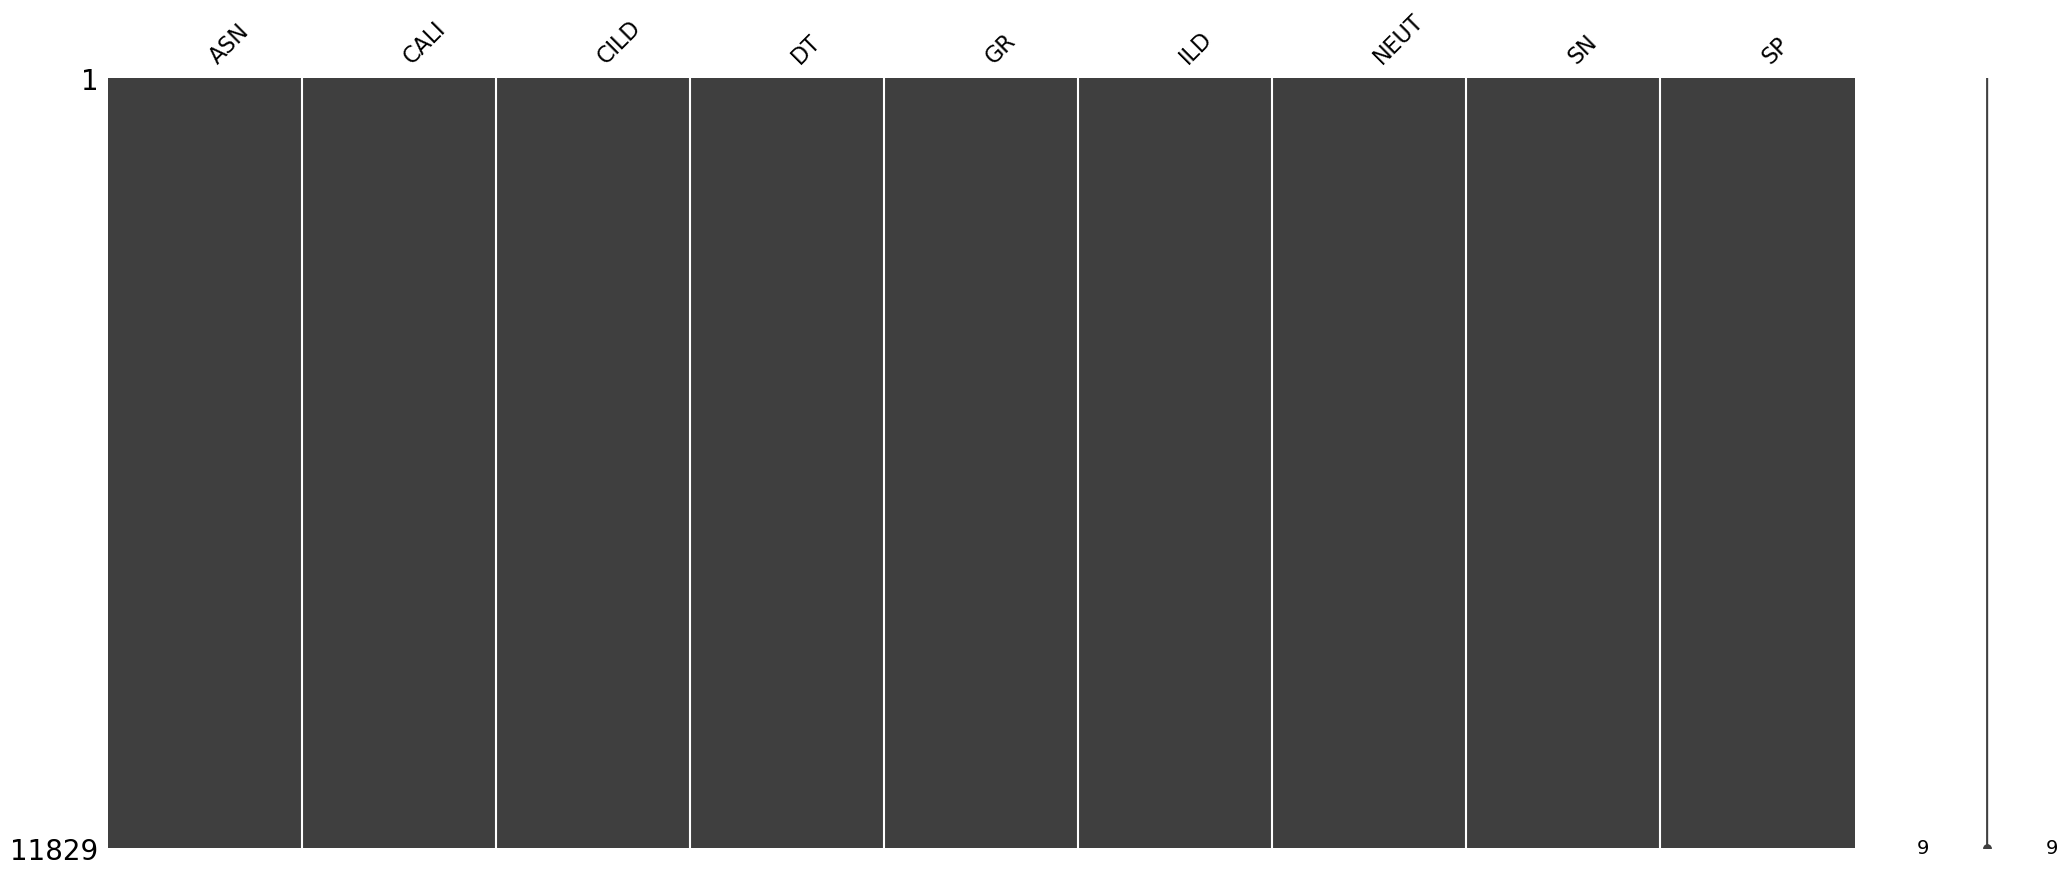

In [73]:
# Cleaning Data
df.dropna(inplace=True)
print(df)
df_DropNan = df.dropna()
msno.matrix(df_DropNan)

In [74]:
# Applying the functions on the dataset
df['Porosity'] = df['DT'].apply(calculate_porosity)
df['Permeability'] = df['ASN'].apply(lambda x: calculate_permeability(x, 0.2))  # Example parameter
df['Resistivity'] = df['ILD'].apply(calculate_resistivity)

In [75]:
# Adding Target Column
def cocok_eor_ccus(row):
    if row['Porosity'] > 0.02 and row['Permeability'] > 1000 and row['Resistivity'] > 10:
        return 1  # Applicable
    else:
        return 0  # Not

df['Suitable'] = df.apply(cocok_eor_ccus, axis=1)

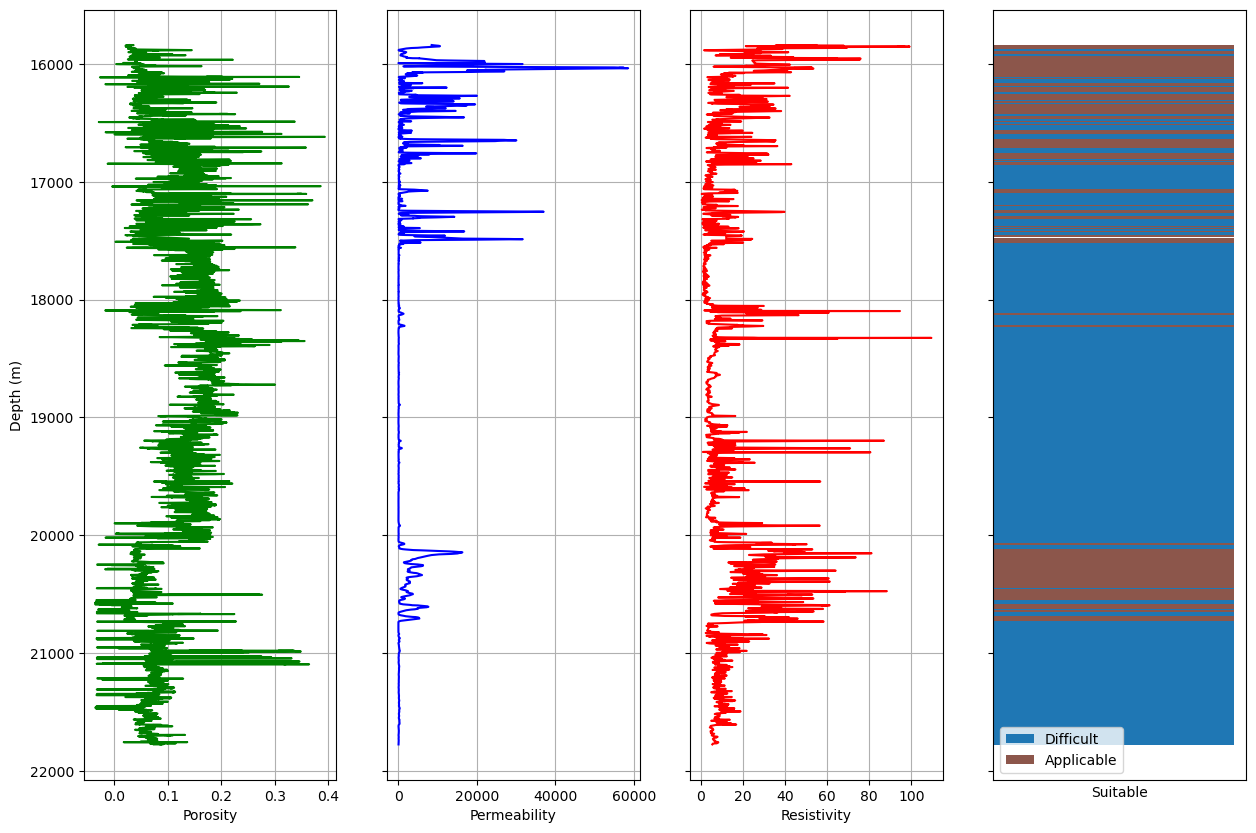

In [92]:
# Plot well log
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 10), sharey=True)

# Porosity
axes[0].plot(df['Porosity'], df.index, color='green')
axes[0].set_xlabel('Porosity')
axes[0].grid()
axes[0].set_ylabel('Depth (m)')

# Permeability
axes[1].plot(df['Permeability'], df.index, color='blue')
axes[1].set_xlabel('Permeability')
axes[1].invert_yaxis()
axes[1].grid()

# Resistivity
axes[2].plot(df['Resistivity'], df.index, color='red')
axes[2].set_xlabel('Resistivity')
axes[2].invert_yaxis()
axes[2].grid()

# Suitability
suitability = df['Suitable']
cmap = plt.get_cmap('tab20')
unique_suitability = np.unique(suitability)
suitability_colors = {f: cmap(i / len(unique_suitability)) for i, f in enumerate(unique_suitability)}

suitability_labels = {0: 'Difficult', 1: 'Applicable'}

for f in unique_facies:
    mask = suitability == f
    axes[3].barh(
        df.index[mask],  
        width=1000,  
        height=5,  
        color=suitability_colors[f],
        label=suitability_labels.get(f, f)  # Use the dictionary for labels
    )

axes[3].invert_yaxis()
axes[3].set_xlabel('Suitable')
axes[3].set_xticks([])
axes[3].legend(loc='lower left')


In [77]:
df.to_csv('parameter.csv')
dataset = pd.read_csv('parameter.csv')
print (dataset)

#Feature Selection
features = dataset[['DEPT', 'Porosity', 'Permeability', 'Resistivity']]
target = dataset['Suitable']

          DEPT        ASN       CALI       CILD        DT          GR  \
0      15840.0  25.689130  12.615200   11.07158  49.54193  1336.38800   
1      15840.5  25.777130  12.612830   11.14999  50.11654  1334.63600   
2      15841.0  25.865130  12.627050   12.36201  50.60372  1336.32100   
3      15841.5  25.953130  12.647060   14.44074  49.81141  1342.33100   
4      15842.0  26.070920  12.661060   16.34844  50.16874  1348.37000   
...        ...        ...        ...        ...       ...         ...   
11824  21772.0   4.231453   6.018427  280.45270  58.12004    30.30164   
11825  21772.5   4.250344   6.020710  261.98400  58.87687    30.67397   
11826  21773.0   4.229763   6.022975  261.98400  58.86103    30.40106   
11827  21773.5   4.199735   6.015613  269.07460  57.50124    28.85058   
11828  21774.0   4.169695   6.014866  285.09400  56.47565    26.62263   

             ILD       NEUT         SN        SP  Porosity  Shale Volume  \
0      54.875060  1686.7040  24.964460 -69.2719

In [78]:
# Data Normalization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#Training and Testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=100)

# Train model
model = RandomForestClassifier(random_state=100)

In [79]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {np.mean(cv_scores)}')

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

Cross-validation scores: [1.         1.         0.99929528 1.         0.99929528]
Mean CV score: 0.9997181113460183


In [80]:
# Performance Validation Metrics
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Save the model if needed
import joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00       947

    accuracy                           1.00      4732
   macro avg       1.00      1.00      1.00      4732
weighted avg       1.00      1.00      1.00      4732

[[3785    0]
 [   0  947]]


['best_random_forest_model.pkl']

In [82]:
# Generate synthetic dataset for classification
X, y = make_classification(
    n_samples=1000,         # Number of samples
    n_features=5,           # Number of features
    n_informative=3,        # Number of informative features
    n_redundant=1,          # Number of redundant features
    n_classes=2,            # Number of classes (binary classification)
    random_state=42,        # For reproducibility
    weights=[0.8, 0.2],     # Class imbalance (80% of class 0, 20% of class 1)
)

In [84]:
# Convert to DataFrame for better visualization
synthetic_df = pd.DataFrame(X, columns=['DEPT', 'Porosity', 'Permeability', 'Resistivity', 'Shale Volume'])
synthetic_df['Suitable'] = y

# Show the first few rows of the synthetic dataset
print(synthetic_df)

         DEPT  Porosity  Permeability  Resistivity  Shale Volume  Suitable
0   -0.038769 -0.649239     -0.224746    -1.346275      0.126879         0
1    1.005284 -1.373239      1.157346     0.126493      1.422799         0
2   -0.742455 -0.573257      1.688442    -2.588237      0.762562         0
3    2.440938 -2.556425     -0.930664     0.111514     -1.133170         0
4   -0.941758  0.367913     -0.549360    -2.029919     -1.503957         0
..        ...       ...           ...          ...           ...       ...
995  0.678309 -1.671163      1.626380    -0.773871      2.621597         0
996 -0.879184  1.222463     -0.144288     1.235924      2.155361         1
997  0.645919 -1.072594      0.487905    -0.484703      0.435138         0
998 -0.108734 -0.749541      1.490379    -1.519751      0.625013         0
999  0.737432 -1.084443     -0.426269    -0.512985     -0.132273         0

[1000 rows x 6 columns]


In [85]:
synthetic_df.to_csv('synthetic_data.csv', index=False)

dataset = pd.read_csv('synthetic_data.csv')

# Feature Selection
features = dataset[['DEPT', 'Porosity', 'Permeability', 'Resistivity']]
target = dataset['Suitable']

# Data Normalization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Training and Testing
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.4, random_state=100)

# Train model
model = RandomForestClassifier(random_state=100)

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {np.mean(cv_scores)}')

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Performance Validation Metrics
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Cross-validation scores: [0.96666667 0.94166667 0.95833333 0.94166667 0.95      ]
Mean CV score: 0.9516666666666668
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       317
           1       0.95      0.88      0.91        83

    accuracy                           0.96       400
   macro avg       0.96      0.93      0.95       400
weighted avg       0.96      0.96      0.96       400

[[313   4]
 [ 10  73]]
